Author
*   L00177556
*   Ankush Arya



# Motivation

### Bayesian Networks
A Bayesian network is a directed acyclic graph with each edge representing a conditional dependency and each node representing a distinct random variable.

A Bayesian network is made up of two fundamental components: a directed acyclic graph and a collection of conditional probability distributions.

Using Directed Acyclic Graphs (DAG), Bayesian Networks are used to model uncertainties.

The nodes represent random variables, while the edges establish the link between these variables.

In this task, I will compute conditional probabilities from data and select the random variable that has evidence for the target variable.

Install the required packages

In [1]:
!pip install pgmpy
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
# PyLab is a procedural interface to the object-oriented charting toolkit Matplotlib, 
# and it is used to examine large complex networks represented as graphs with nodes and edges.
import pylab

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.feature_selection import SelectKBest, chi2

In [4]:
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
#pe = ParameterEstimator(best_model, data)
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
# Infering the posterior probability
from pgmpy.inference import VariableElimination
from pandas.core.groupby.groupby import DataFrame

In [5]:
# upload data from local disk
import io

from google.colab import files
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['lymphography_data.csv']))
df_copy = df.copy()

Saving lymphography_data.csv to lymphography_data (1).csv


In [23]:
# restore from the copy for a rerun
df = df_copy

# show first 5 rows
df.head()

,Class,Lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym,defect in node,changes in node,changes in stru,special forms,dislocation of,exclusion of no,no. of nodes in
0,3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
1,2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
2,3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
4,2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


In [24]:
# look at the data types and null values in the columns
# there are no null values in the data , and data is clean, no need for any preprocessing to clean the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Class             148 non-null    int64
 1   Lymphatics        148 non-null    int64
 2   block of affere   148 non-null    int64
 3   bl. of lymph. c   148 non-null    int64
 4   bl. of lymph. s   148 non-null    int64
 5   by pass           148 non-null    int64
 6   extravasates      148 non-null    int64
 7   regeneration of   148 non-null    int64
 8   early uptake in   148 non-null    int64
 9   lym.nodes dimin   148 non-null    int64
 10  lym.nodes enlar   148 non-null    int64
 11  changes in lym    148 non-null    int64
 12   defect in node   148 non-null    int64
 13   changes in node  148 non-null    int64
 14  changes in stru   148 non-null    int64
 15  special forms     148 non-null    int64
 16  dislocation of    148 non-null    int64
 17  exclusion of no   148 non-null    i

In [25]:
# another way to know the null values in the dataset
df.isnull().sum()

Class               0
Lymphatics          0
block of affere     0
bl. of lymph. c     0
bl. of lymph. s     0
by pass             0
extravasates        0
regeneration of     0
early uptake in     0
lym.nodes dimin     0
lym.nodes enlar     0
changes in lym      0
 defect in node     0
 changes in node    0
changes in stru     0
special forms       0
dislocation of      0
exclusion of no     0
no. of nodes in     0
dtype: int64

In [26]:
# Get the distribution of observations per Class in the dataset
df['Class'].value_counts()

2    81
3    61
4     4
1     2
Name: Class, dtype: int64

In [27]:
# Here we can ignore observations in Class 4 and 1, as these are very few to make any predictions from the dataset
df = df[(df.Class != 1) & (df.Class != 4)]
# df = df[(df.Class != 1) ]
df['Class'].value_counts()

2    81
3    61
Name: Class, dtype: int64

In [28]:
# feature selection function, used later in the code
def select_features(X_train, y_train, X_test, k='all'):
    # Create and fit selector
    selector = SelectKBest(score_func=chi2, k=k).fit(X_train, y_train)

    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    X_train_features = X_train.iloc[:,cols]
    X_test_features = X_test.iloc[:,cols]
    return X_train_features, X_test_features, selector, cols

In [29]:
# load the X and y variablesfrom the dataset
X = df.drop(['Class'], axis=1)

y = df['Class']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

Feature  0:, 0.2436 Lymphatics
Feature  1:, 3.7128 block of affere
Feature  2:, 0.5147 bl. of lymph. c
Feature  3:, 0.0236 bl. of lymph. s
Feature  4:, 0.5143 by pass
Feature  5:, 0.0212 extravasates
Feature  6:, 0.1231 regeneration of
Feature  7:, 1.7235 early uptake in
Feature  8:, 0.0125 lym.nodes dimin
Feature  9:, 3.6409 lym.nodes enlar
Feature 10:, 0.2500 changes in lym
Feature 11:, 0.0604  defect in node
Feature 12:, 0.6186  changes in node
Feature 13:, 7.5556 changes in stru
Feature 14:, 2.7168 special forms
Feature 15:, 0.5156 dislocation of
Feature 16:, 0.3441 exclusion of no
Feature 17:, 37.4944 no. of nodes in


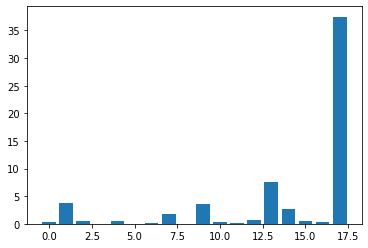

In [30]:
# feature selection, from the X variables only
X_train_fs, X_test_fs, fs, cols = select_features(X_train, y_train, X_test)

# print the scores 
for i in range(len(fs.scores_)):
    print(f'Feature {i:2}:, {fs.scores_[i]:.4f} {X_train_fs.columns[cols[i]]}')
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

I have taken all the scores in the excel sheet columns to understand the threshold score to select the features.  

In [31]:
# feature selection, with k=8 features
X_train_fs, X_test_fs, fs , cols= select_features(X_train, y_train, X_test, k=8)

# check the size of the datasets 
print(f'size of X_train:{X_train_fs.shape}\nsize of X_test :{X_test_fs.shape}\nsize of y_train:{y_train.shape}\nsize of y_test :{y_test.shape}')

# combining the dataframe 
data = X_train_fs.join(y_train)

size of X_train:(99, 8)
size of X_test :(43, 8)
size of y_train:(99,)
size of y_test :(43,)


In [32]:
# print the selected feaures with their scores
for i in range(len(cols)):
    indx = cols[i]
    print(f'Selected Feature {indx:2}:, Scores: {fs.scores_[indx]:2.4f}, Name : {X_train_fs.columns[i]}')

Selected Feature  1:, Scores: 3.7128, Name : block of affere
Selected Feature  7:, Scores: 1.7235, Name : early uptake in
Selected Feature  9:, Scores: 3.6409, Name : lym.nodes enlar
Selected Feature 12:, Scores: 0.6186, Name :  changes in node
Selected Feature 13:, Scores: 7.5556, Name : changes in stru
Selected Feature 14:, Scores: 2.7168, Name : special forms
Selected Feature 15:, Scores: 0.5156, Name : dislocation of
Selected Feature 17:, Scores: 37.4944, Name : no. of nodes in


The formula for calculations

> P(A|B) = P(B|A)*P(A)/P(B)

> where P(A) is prior probability, P(B) is evidence, P(B|A) is the likelihood function.


In [33]:
# Calculating scores
# Computes a score that measures how much a given variable is “influenced” by a given list of potential parents.
bic = BicScore(data)

# To obtain the Bayesian net structure that is the best model we use HillClimbSearch 
# implements a greedy local search that starts from the DAG start (default: disconnected DAG) and 
# proceeds by iteratively performing single-edge manipulations that maximally increase the score. 
# The search terminates once a local maximum is found.
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=bic)
print(sorted(best_model.nodes()))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[' changes in node', 'Class', 'block of affere', 'changes in stru', 'dislocation of', 'early uptake in', 'lym.nodes enlar', 'no. of nodes in', 'special forms']
[('lym.nodes enlar', 'Class'), ('dislocation of', 'lym.nodes enlar'), ('Class', ' changes in node'), ('Class', 'block of affere'), ('Class', 'special forms'), ('Class', 'early uptake in'), ('Class', 'no. of nodes in')]


In [34]:
print(type(best_model))

model_final = BayesianNetwork(best_model)
print(type(model_final))

<class 'pgmpy.base.DAG.DAG'>
<class 'pgmpy.models.BayesianNetwork.BayesianNetwork'>


In [35]:
model_final.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in model_final.get_cpds():
    print(cpd)

+--------------------+--------------------+---------------------+
| Class              | Class(2)           | Class(3)            |
+--------------------+--------------------+---------------------+
| block of affere(1) | 0.1782608695652174 | 0.6505376344086021  |
+--------------------+--------------------+---------------------+
| block of affere(2) | 0.8217391304347826 | 0.34946236559139787 |
+--------------------+--------------------+---------------------+
+--------------------+--------------------+--------------------+
| Class              | Class(2)           | Class(3)           |
+--------------------+--------------------+--------------------+
| early uptake in(1) | 0.4217391304347826 | 0.0913978494623656 |
+--------------------+--------------------+--------------------+
| early uptake in(2) | 0.5782608695652174 | 0.9086021505376344 |
+--------------------+--------------------+--------------------+
+--------------------+----------------------+---------------------+
| dislocation o

In [36]:
print(X_test_fs[0: 1])

    block of affere  early uptake in  lym.nodes enlar   changes in node  \
82                1                2                3                 2   

    changes in stru  special forms  dislocation of  no. of nodes in  
82                8              3               2                5  


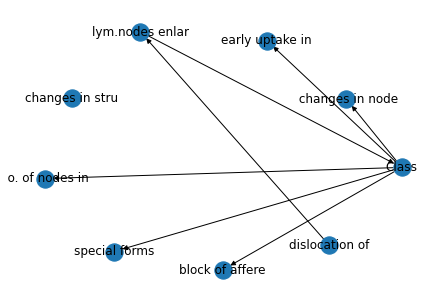

In [37]:
# Printing the model using PyLab
nx.draw(model_final, with_labels=True)

Now that I've drawn a network diagram, I can see that the "lym node enlar" is the evidence node, as indicated by the directed edge leading from it to the Class node. The posterior probability is what I'll be calculating next.

In [38]:
infer = VariableElimination(model_final)
# Evidence is needed to be given when we are evaluating posterior probability,
# We have to infer Cancer Ind from the other features

num_rows, num_cols = X_test.shape
print(num_rows)
posterior_py = np.empty(shape=(num_rows,2))
print(posterior_py.shape)
print(X_test.columns)


43
(43, 2)
Index(['Lymphatics', 'block of affere', 'bl. of lymph. c', 'bl. of lymph. s',
       'by pass', 'extravasates', 'regeneration of', 'early uptake in',
       'lym.nodes dimin', 'lym.nodes enlar', 'changes in lym',
       ' defect in node', ' changes in node', 'changes in stru',
       'special forms', 'dislocation of', 'exclusion of no',
       'no. of nodes in'],
      dtype='object')


In [39]:
# Looking how the output looks like I attain the probability of Class variable belong to category 2 or 3
result = infer.query(['Class'], evidence={'lym.nodes enlar': X_test.iat[0,5]})
print(result)

+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.5800 |
+----------+--------------+
| Class(3) |       0.4200 |
+----------+--------------+


In [40]:
# we have four different values in the "lym. nodes enlar" feature 
df['lym.nodes enlar'].value_counts()

2    70
3    43
4    20
1     9
Name: lym.nodes enlar, dtype: int64

In [41]:
print('\n1. Probability of Class given evidence is "lym.nodes enlar" = 2')
q1=infer.query(variables=['Class'],evidence={'lym.nodes enlar':1})
print(q1)


1. Probability of Class given evidence is "lym.nodes enlar" = 2
+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.5800 |
+----------+--------------+
| Class(3) |       0.4200 |
+----------+--------------+


Lets find the probabilities of various values impacting the Class target variable

In [42]:
for i in range(1, len(df['lym.nodes enlar'].value_counts())+1):
  print(f'\nProbability of Class given evidence is "lym.nodes enlar" = {i}')
  q=infer.query(variables=['Class'],evidence={'lym.nodes enlar':i})
  print(q)


Probability of Class given evidence is "lym.nodes enlar" = 1
+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.5800 |
+----------+--------------+
| Class(3) |       0.4200 |
+----------+--------------+

Probability of Class given evidence is "lym.nodes enlar" = 2
+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.7289 |
+----------+--------------+
| Class(3) |       0.2711 |
+----------+--------------+

Probability of Class given evidence is "lym.nodes enlar" = 3
+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.4504 |
+----------+--------------+
| Class(3) |       0.5496 |
+----------+--------------+

Probability of Class given evidence is "lym.nodes enlar" = 4
+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(2) |       0.2101 |
+----------+--------------+
| Class(3) |       0.789

# Conclusion


According to these probabilities, the numbers 2 and 4 for the "Lym Node enlar" more clearly suggest the value of the Class variable. For instance, if "lym.nodes enlar" = 2, then the Class variable is more likely to have the value 2 (72.89%) or the value 3 (27.11%).

I have also run the program cosdering 3 values of the Class variables, the resukts as under, I noticed that there is not much separation between the classes, for example for lym.nodes enlar = 3 where the sepration between class 2 and class3 is very less. Again for lym.nodes enlar=1 for Class 4 is very less and close to zero, similar is the case with all the values of lym.Nodes Enlar, hence better is to drop the observations related to Class 4

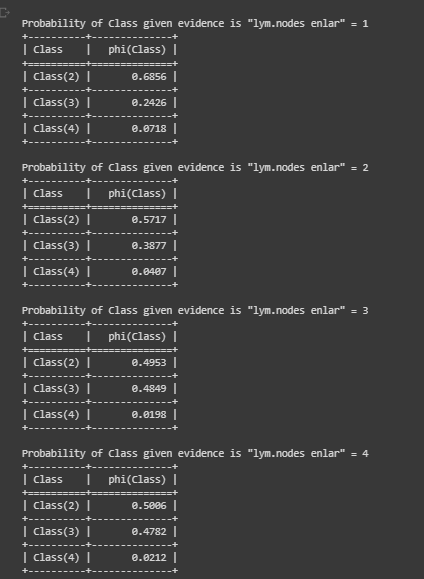